Reported by: Natasha Flores (24-april-2025)

Exporting REACT results to shapefiles (a shapefile per year in this case)

In [1]:
import os
import sys
import xugrid as xu
import xarray as xr
sys.path.insert(1, '../library')
from DEcoImpact_exp_func import DEIOutput


In [2]:
#configuration

#list with input locations of D-Eco Impact export file that needs to be converted
list_ds_in = [r'../results/SpongeWorks/results_REACT_WFLOW_Eflows_Vecht_2017_2023.nc'] 

# list with variables that need to be exported to shapefile. Note, these should only contain faces as axes (no time or depth etc).
rename_list_variabels = {'REACT_eflows_masked_Type_Low'   : 'TypeLow',
                         'REACT_eflows_masked_Type_Inter' : 'TypeInter',
                         'REACT_eflows_masked_Type_High'  : 'TypeHigh',
                         }

#output path location for shapefile data created 
output_path = r'example_output_data/shapefile_output_eflows'

#make sure the folders to output path exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

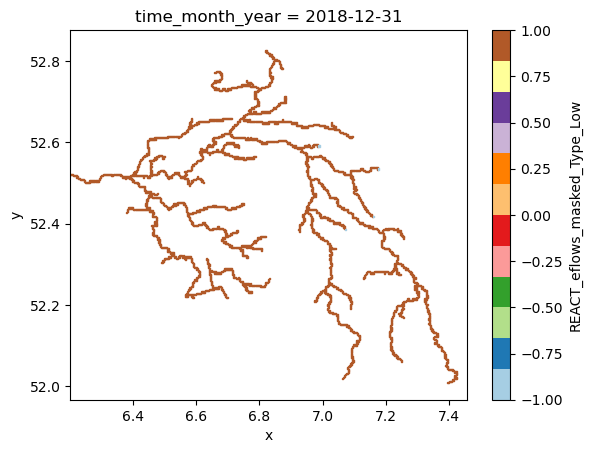

In [3]:
#read and show result
#Show result of one specific year for 
uda_map = xu.open_mfdataset(list_ds_in)
uda_map["REACT_eflows_masked_Type_Low"].sel(time_month_year= "2018-12-31 00:00:00").ugrid.plot(cmap = "Paired")


In [4]:
#export a seperate Netcdf per year to convert to shapefile and adapt variable names so they fit the shapefile column
uda_map = uda_map.rename_vars(rename_list_variabels)
subsetted_uda_map = uda_map[list(rename_list_variabels.values())]

list_ds_in_per_year = []

#export a netcdf file per year calculated and store the path
for time_month_year_value in uda_map.time_month_year.values:
    time_subsetted_uda_map = subsetted_uda_map.sel(time_month_year = time_month_year_value)
    year = time_month_year_value.astype('datetime64[Y]').astype(int) + 1970
    file_path = "results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_" + str(year) + ".nc"
    list_ds_in_per_year.append(file_path)
    time_subsetted_uda_map.ugrid.to_netcdf(file_path)


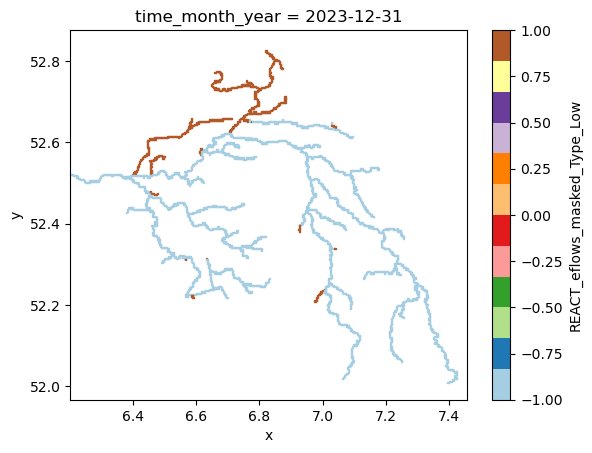

In [5]:
#read and show result
#Show result of one specific year for 
uda_map_test = xu.open_mfdataset(list_ds_in_per_year[-1])
uda_map_test["TypeLow"].ugrid.plot(cmap = "Paired")


In [6]:
#initialize
DEIresults = DEIOutput()
cwd = os.getcwd()
DEIresults.set_root(root = cwd)

#Add paths to the result NetCDF(s) (skip first of list as 2010 has no data due to rolling statistic)
DEIresults.set_paths_to_DEIresults(input_list_path = list_ds_in_per_year[1:])

#Export to Shapefile
DEIresults.translate_UgridNetCDFs_to_Shape(
    list_variables = list(rename_list_variabels.values()),
    output_path = output_path
)

print("Done.")

Start with results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2018.nc
Exported example_output_data/shapefile_output_eflows\to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2018
Start with results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2019.nc
Exported example_output_data/shapefile_output_eflows\to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2019
Start with results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2020.nc
Exported example_output_data/shapefile_output_eflows\to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2020
Start with results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2021.nc
Exported example_output_data/shapefile_output_eflows\to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2021
Start with results/to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2022.nc
Exported example_output_data/shapefile_output_eflows\to_shape_results_REACT_WFLOW_Eflows_simple_SpongeWorks_2022
Start with results/to_sha

In [ ]:
## This is optional and good for comparison with the later produced geopackage. 
## This is a simple summary of the counts  of each variable value per year and overall 
# --- Summarize shapefile results: counts of -1, 0, 1 per variable and year ---
import geopandas as gpd
import pandas as pd
import re
from pathlib import Path

# Directory where shapefiles were written
output_dir = Path(output_path)

# Variables and their attribute names in the shapefiles
target_vars = list(rename_list_variabels.values())  # ['TypeLow', 'TypeInter', 'TypeHigh']

# Helper: extract year from filename (e.g., "..._2020.shp" or "...2020-12-31.shp")
year_pattern = re.compile(r'(?P<year>19\d{2}|20\d{2})')

def extract_year_from_name(name: str) -> int | None:
    m = year_pattern.search(name)
    if m:
        return int(m.group('year'))
    return None

# Collect per-file, per-variable counts
rows = []

# Find all shapefiles in output directory (recursively, in case of subfolders)
shp_files = list(output_dir.rglob("*.shp"))
if not shp_files:
    print(f"⚠️ No shapefiles found under: {output_dir.resolve()}")

for shp in shp_files:
    try:
        gdf = gpd.read_file(shp)
    except Exception as e:
        print(f"⚠️ Could not read {shp}: {e}")
        continue

    # Try to infer year from filename
    year = extract_year_from_name(shp.stem)

    # For each target variable, if it exists in this shapefile, count values
    for var in target_vars:
        if var not in gdf.columns:
            # Not all shapefiles necessarily contain all variables; skip quietly
            continue

        s = gdf[var]

        # Keep only finite numeric values; convert if needed
        s_num = pd.to_numeric(s, errors='coerce').dropna()

        counts = s_num.value_counts()
        n_neg1 = int(counts.get(-1, 0))
        n_0    = int(counts.get(0, 0))
        n_1    = int(counts.get(1, 0))
        n_total = int(len(s_num))

        rows.append({
            "variable": var,
            "year": year,   # None if year not detected
            "file": str(shp),
            "count_-1": n_neg1,
            "count_0":  n_0,
            "count_1":  n_1,
            "count_total_numeric": n_total,
        })

# Assemble DataFrame
summary_df = pd.DataFrame(rows)

if not summary_df.empty:
    # Per-year summary (summing across files for same var-year)
    per_year = (summary_df
                .groupby(["variable", "year"], dropna=False)[["count_-1", "count_0", "count_1", "count_total_numeric"]]
                .sum()
                .reset_index()
               ).sort_values(["variable", "year"])

    # Overall summary per variable (across all years/files)
    overall = (summary_df
               .groupby("variable")[["count_-1", "count_0", "count_1", "count_total_numeric"]]
               .sum()
               .reset_index()
              ).sort_values("variable")

    # Write outputs
    out_csv_per_year = output_dir / "summary_counts_per_year.csv"
    out_csv_overall  = output_dir / "summary_counts_overall.csv"
    per_year.to_csv(out_csv_per_year, index=False)
    overall.to_csv(out_csv_overall, index=False)

    # Display a small preview
    print("\n✅ Summary written:")
    print(f"  - {out_csv_per_year}")
    print(f"  - {out_csv_overall}")
    print("\nPer-year preview:")
    print(per_year.head(10).to_string(index=False))
    print("\nOverall:")
    print(overall.to_string(index=False))
else:
    print("ℹ️ No variable counts were collected. Check that shapefiles contain the expected fields: "
          f"{target_vars} and that files exist under {output_dir.resolve()}.")



✅ Summary written:
  - example_output_data\shapefile_output_eflows\summary_counts_per_year.csv
  - example_output_data\shapefile_output_eflows\summary_counts_overall.csv

Per-year preview:
 variable   year  count_-1  count_0  count_1  count_total_numeric
 TypeHigh 2018.0         0     2584        0                 2584
 TypeHigh 2019.0         0     2584        0                 2584
 TypeHigh 2020.0         0     2584        0                 2584
 TypeHigh 2021.0         0     2584        0                 2584
 TypeHigh 2022.0         0     2584        0                 2584
 TypeHigh 2023.0         0     2584        0                 2584
 TypeHigh    NaN         0    15504        0                15504
TypeInter 2018.0         0     2517       67                 2584
TypeInter 2019.0        21     2531       32                 2584
TypeInter 2020.0         0     2584        0                 2584

Overall:
 variable  count_-1  count_0  count_1  count_total_numeric
 TypeHigh      

In [ ]:
# -*- coding: utf-8 -*-
"""
From yearly shapefiles (EPSG:4326) to:
  1) One GeoPackage with a single combined layer 'eflows_all_years' in EPSG:28992,
  2) One wide CSV (rows = variable, year) with:
       total_km2, km2_-1, km2_0, km2_1, pct_-1, pct_0, pct_1  (percentages in 0–1),
  3) One *separate* CSV (rows = variable) with temporal consistency metrics in 0–100:
       cells_total, tc_mean_pct, tc_median_pct, tc_ge_80_pct, tc_ge_50_pct, tc_100_pct.
            cells_total (number of cells considered),
            tc_mean, tc_median (mean/median consistency),
            tc_ge_80_pct (fraction of cells with consistency ≥ 0.80),
            tc_100_pct (fraction of cells perfectly consistent = 1.0).
            (These consistency metrics are constant across years for a given variable, so they are repeated on each year row.)

Assumptions
- Input shapefiles live under `input_dir` and each filename contains a 4‑digit year.
- Class variables are 'TypeLow', 'TypeInter', 'TypeHigh' with values in {-1, 0, 1}.
- Initial CRS is EPSG:4326 (set if missing), reproject to EPSG:28992 for area.

Author: (you)
"""

import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import hashlib
import re

# ----------------------------
# CONFIGURATION
# ----------------------------

# Directory containing the yearly shapefiles you exported earlier
input_dir = Path(r'example_output_data/shapefile_output_eflows')

# Single GeoPackage (combined layer only)
gpkg_path = input_dir / "eflows_28992_all_years.gpkg"
combined_layer_name = "eflows_all_years"

# Variables (categorical outputs on the faces/cells)
variables = ["TypeLow", "TypeInter", "TypeHigh"]

# Expected classes (order used in CSV columns)
classes = [-1, 0, 1]

# CRS constants
CRS_SOURCE = "EPSG:4326"   # Original CRS (WGS84)
CRS_AREA   = "EPSG:28992"  # Area-appropriate CRS for NL (meters)

# CSV outputs
csv_area_wide = input_dir / "eflows_area_by_class_wide.csv"
csv_consistency = input_dir / "eflows_temporal_consistency_per_variable.csv"


# ----------------------------
# HELPERS
# ----------------------------

def find_yearly_shapefiles(root: Path) -> list[Path]:
    """Find all .shp files recursively under the given folder."""
    return sorted(root.rglob("*.shp"))

def extract_year_from_name(path: Path) -> int | None:
    """Extract the last 4-digit year from a filename's stem."""
    hits = re.findall(r"(19\d{2}|20\d{2})", path.stem)
    return int(hits[-1]) if hits else None

def ensure_source_crs(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    If a shapefile lacks CRS, set EPSG:4326 (per your data).
    If CRS exists (even if different), accept it—next step reprojects anyway.
    """
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_SOURCE)
    return gdf

def to_area_crs(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Reproject to EPSG:28992 to enable correct area calculations (m²/km²).
    """
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_SOURCE)
    if (gdf.crs.to_epsg() or "") != 28992:
        gdf = gdf.to_crs(CRS_AREA)
    return gdf

def ensure_area_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Ensure per-feature 'area_m2' and 'area_km2' exist (computed in EPSG:28992)."""
    if "area_m2" not in gdf.columns:
        gdf["area_m2"] = gdf.geometry.area
    if "area_km2" not in gdf.columns:
        gdf["area_km2"] = gdf["area_m2"] / 1_000_000.0
    return gdf

def to_int_class(series: pd.Series) -> pd.Series:
    """
    Convert class series robustly to {-1,0,1} as nullable Int64:
    - numeric coercion, keep NaN, then round and cast.
    """
    s = pd.to_numeric(series, errors="coerce")
    return s.round().astype("Int64")

def detect_cell_id_column(columns: list[str]) -> str | None:
    """Try to detect an existing face/cell identifier."""
    for c in ["cell_id", "CellID", "face_id", "FaceID", "fid",
              "mesh2d_face", "ugrid_face", "element", "elem_id", "poly_id"]:
        if c in columns:
            return c
    return None

def make_geom_hash(geom) -> str:
    """Stable fallback ID: MD5 hash of geometry WKB."""
    return hashlib.md5(geom.wkb).hexdigest()


# ----------------------------
# 1) READ SHAPEFILES → 28992 → COMBINE → WRITE GPKG (combined only)
# ----------------------------

shp_files = find_yearly_shapefiles(input_dir)
if not shp_files:
    raise FileNotFoundError(f"No shapefiles found under: {input_dir.resolve()}")

records = []
for shp in shp_files:
    year = extract_year_from_name(shp)
    if year is None:
        # Skip files without a recognizable year in their name
        continue

    try:
        gdf = gpd.read_file(shp)
    except Exception as e:
        print(f"⚠️ Could not read {shp}: {e}")
        continue

    # If CRS missing, set EPSG:4326 (your original CRS)
    gdf = ensure_source_crs(gdf)

    # Light geometry repair to avoid topology errors
    try:
        gdf["geometry"] = gdf.geometry.buffer(0)
    except Exception:
        pass

    # Reproject to EPSG:28992 for area computations
    gdf = to_area_crs(gdf)

    # Add year and area fields
    gdf["year"] = int(year)
    gdf = ensure_area_columns(gdf)

    records.append(gdf)

if not records:
    raise RuntimeError("No valid yearly data assembled. Check filenames and shapefile integrity.")

# Combine all years
gdf_all = pd.concat(records, ignore_index=True)

# Ensure a stable cell ID (use existing if present; else geometry hash)
id_col = detect_cell_id_column(gdf_all.columns)
if id_col is None:
    gdf_all["cell_id"] = gdf_all.geometry.apply(make_geom_hash)
    id_col = "cell_id"

# (Re)create the GPKG with only the combined layer
if gpkg_path.exists():
    gpkg_path.unlink()
gdf_all.to_file(gpkg_path, layer=combined_layer_name, driver="GPKG")
print(f"✅ Wrote combined layer '{combined_layer_name}' to {gpkg_path}")


# ----------------------------
# 2) ONE WIDE CSV: per (variable, year) areas and shares (0–1)
# ----------------------------

wide_frames = []

for var in variables:
    if var not in gdf_all.columns:
        print(f"ℹ️ Column '{var}' not found; skipping variable.")
        continue

    # Clean class values; keep only rows with valid class and year
    s_class = to_int_class(gdf_all[var])
    dfv = gdf_all[["year", "area_km2"]].copy()
    dfv["class"] = s_class
    dfv = dfv.dropna(subset=["class", "year"]).copy()
    dfv["class"] = dfv["class"].astype(int)

    # Sum area by (year, class)
    by = (dfv.groupby(["year", "class"], as_index=False)["area_km2"].sum())

    # Pivot to wide: columns = classes (-1,0,1)
    pv = by.pivot_table(index="year", columns="class", values="area_km2", aggfunc="sum").fillna(0.0)

    # Ensure all expected class columns exist and are ordered
    for cl in classes:
        if cl not in pv.columns:
            pv[cl] = 0.0
    pv = pv[[cl for cl in classes]]

    # Totals and shares (0–1)
    pv["total_km2"] = pv.sum(axis=1)
    pct = pv[classes].div(pv["total_km2"].replace(0, np.nan), axis=0).fillna(0.0)

    # Rename to final column names
    pv_km2 = pv.rename(columns={-1: "km2_-1",  0: "km2_0",  1: "km2_1"})
    pct_df = pct.rename(columns={-1: "pct_-1", 0: "pct_0", 1: "pct_1"})

    # Assemble one per-variable table
    out = pd.concat(
        [pv_km2[["total_km2", "km2_-1", "km2_0", "km2_1"]],
         pct_df[["pct_-1", "pct_0", "pct_1"]]],
        axis=1
    ).reset_index()
    out.insert(0, "variable", var)

    wide_frames.append(out)

if not wide_frames:
    raise RuntimeError("No variables summarized; expected columns not present in data.")

area_wide = pd.concat(wide_frames, ignore_index=True).sort_values(["variable", "year"]).reset_index(drop=True)
area_wide.to_csv(csv_area_wide, index=False)
print(f"✅ Wrote area wide CSV: {csv_area_wide}")
print("\nArea CSV preview:")
print(area_wide.head(12).to_string(index=False))


# ----------------------------
# 3) TEMPORAL CONSISTENCY (separate CSV; 0–100)
#    Definition (per cell & variable):
#      consistency = (# years in modal class) / (# valid years)
#    We summarize per variable and report percentages.
# ----------------------------

# Build long-form table for consistency computation
long_rows = []
for var in variables:
    if var not in gdf_all.columns:
        continue
    s_class = to_int_class(gdf_all[var])
    dfv = gdf_all[[id_col, "year"]].copy()
    dfv["variable"] = var
    dfv["class"] = s_class
    dfv = dfv.dropna(subset=["class", "year"])
    long_rows.append(dfv)

if long_rows:
    long_df = pd.concat(long_rows, ignore_index=True)

    # Modal class per (cell, variable)
    modal = (long_df
             .groupby([id_col, "variable"])["class"]
             .agg(lambda x: pd.Series(x).value_counts().idxmax())
             .rename("modal_class")
             .reset_index())

    # Flag rows matching modal class
    tmp = long_df.merge(modal, on=[id_col, "variable"], how="left")
    tmp["is_modal"] = (tmp["class"] == tmp["modal_class"]).astype(int)

    # Per (cell, variable): count years and matches, compute consistency (0–1)
    cons = (tmp.groupby([id_col, "variable"], as_index=False)
            .agg(n_years=("is_modal", "size"),
                 n_modal=("is_modal", "sum")))
    cons["consistency"] = np.where(cons["n_years"] > 0, cons["n_modal"] / cons["n_years"], np.nan)

    # Summarize once per variable and convert to 0–100 (%)
    cons_var = (cons.groupby("variable", as_index=False)
                .agg(cells_total=("consistency", "size"),
                     tc_mean_pct=("consistency", lambda s: s.mean() * 100),
                     tc_median_pct=("consistency", lambda s: s.median() * 100),
                     tc_ge_80_pct=("consistency", lambda s: (s >= 0.8).mean() * 100),
                     tc_ge_50_pct=("consistency", lambda s: (s >= 0.5).mean() * 100),
                     tc_100_pct=("consistency", lambda s: (s >= 1 - 1e-12).mean() * 100)))
else:
    cons_var = pd.DataFrame(columns=[
        "variable", "cells_total", "tc_mean_pct", "tc_median_pct",
        "tc_ge_80_pct", "tc_ge_50_pct", "tc_100_pct"
    ])

# Write the separate consistency CSV (one row per variable)
cons_var = cons_var.sort_values("variable").reset_index(drop=True)
cons_var.to_csv(csv_consistency, index=False)
print(f"✅ Wrote consistency CSV (per variable, %): {csv_consistency}")
print("\nConsistency CSV preview:")
print(cons_var.to_string(index=False))

✅ Wrote combined layer 'eflows_all_years' to example_output_data\shapefile_output_eflows\eflows_28992_all_years.gpkg
✅ Wrote area wide CSV: example_output_data\shapefile_output_eflows\eflows_area_by_class_wide.csv

Area CSV preview:
 variable  year  total_km2    km2_-1      km2_0    km2_1   pct_-1    pct_0    pct_1
 TypeHigh  2018 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
 TypeHigh  2019 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
 TypeHigh  2020 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
 TypeHigh  2021 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
 TypeHigh  2022 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
 TypeHigh  2023 217.272402  0.000000 217.272402 0.000000 0.000000 1.000000 0.000000
TypeInter  2018 217.272402  0.000000 211.632471 5.639931 0.000000 0.974042 0.025958
TypeInter  2019 217.272402  1.768908 212.827238 2.676256 0.008141 0.979541 0.012318
TypeInter  

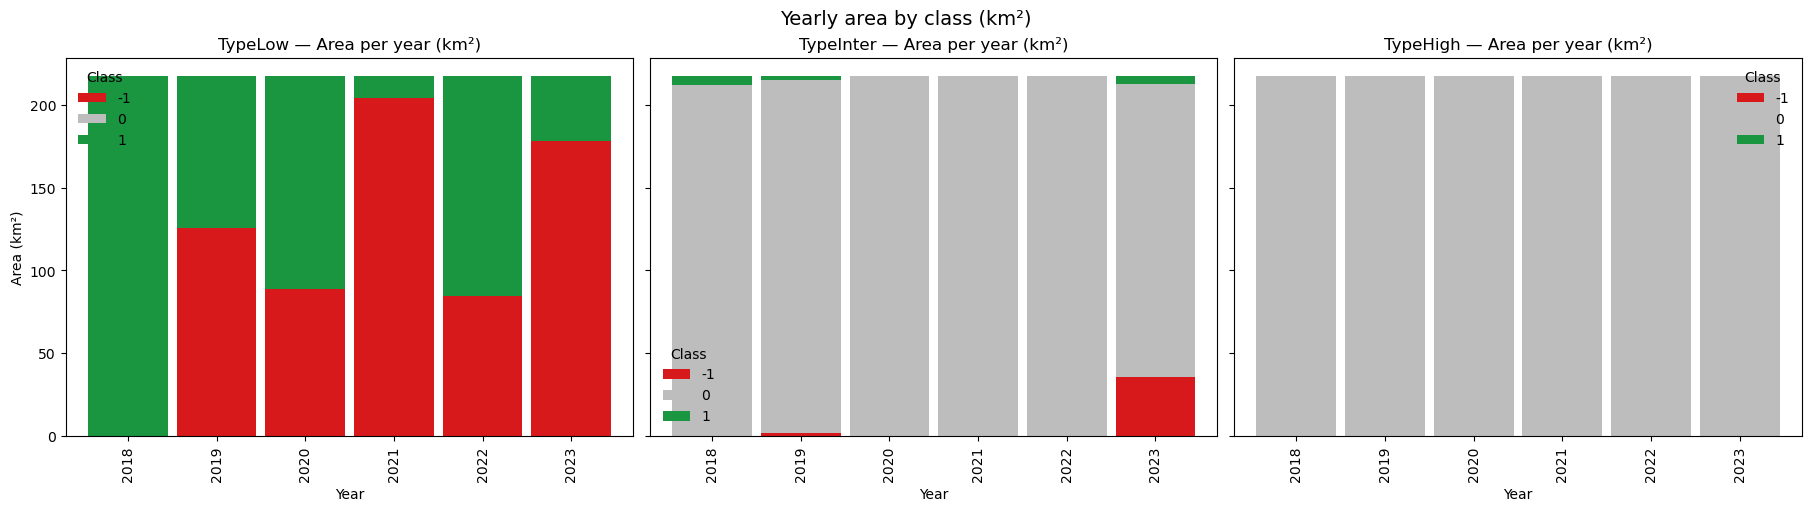

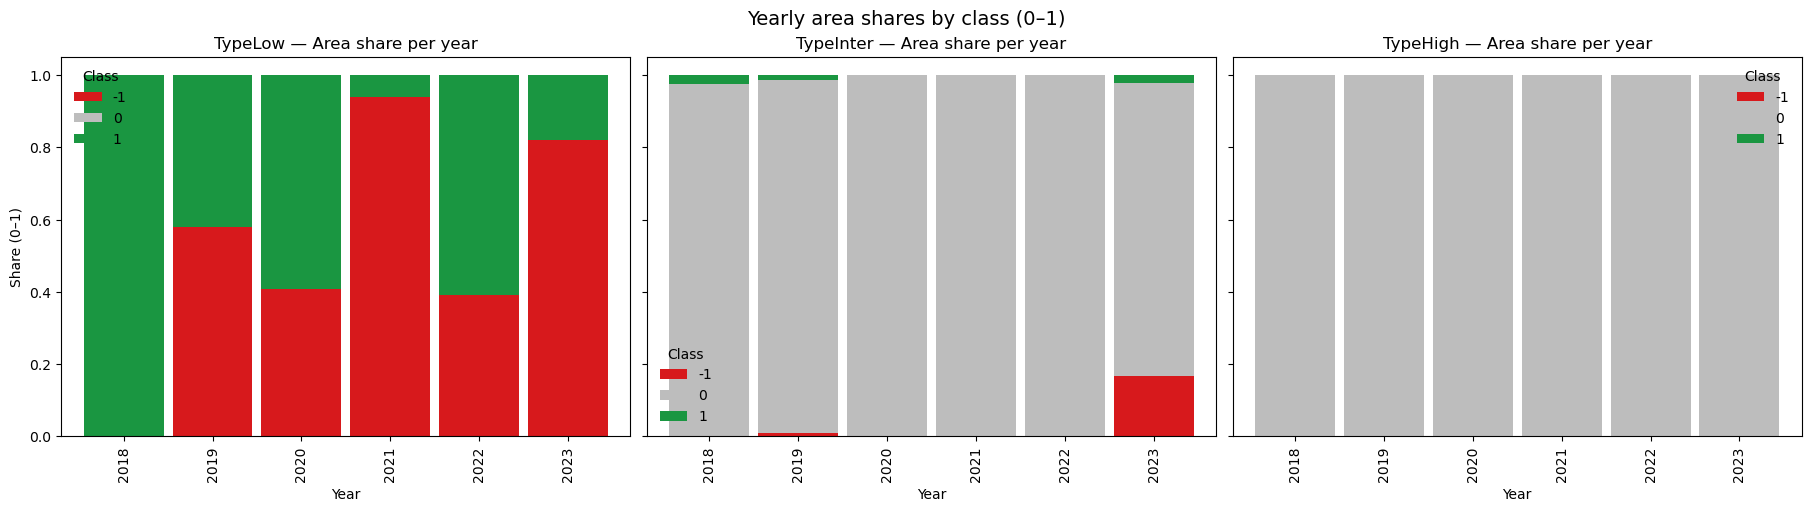

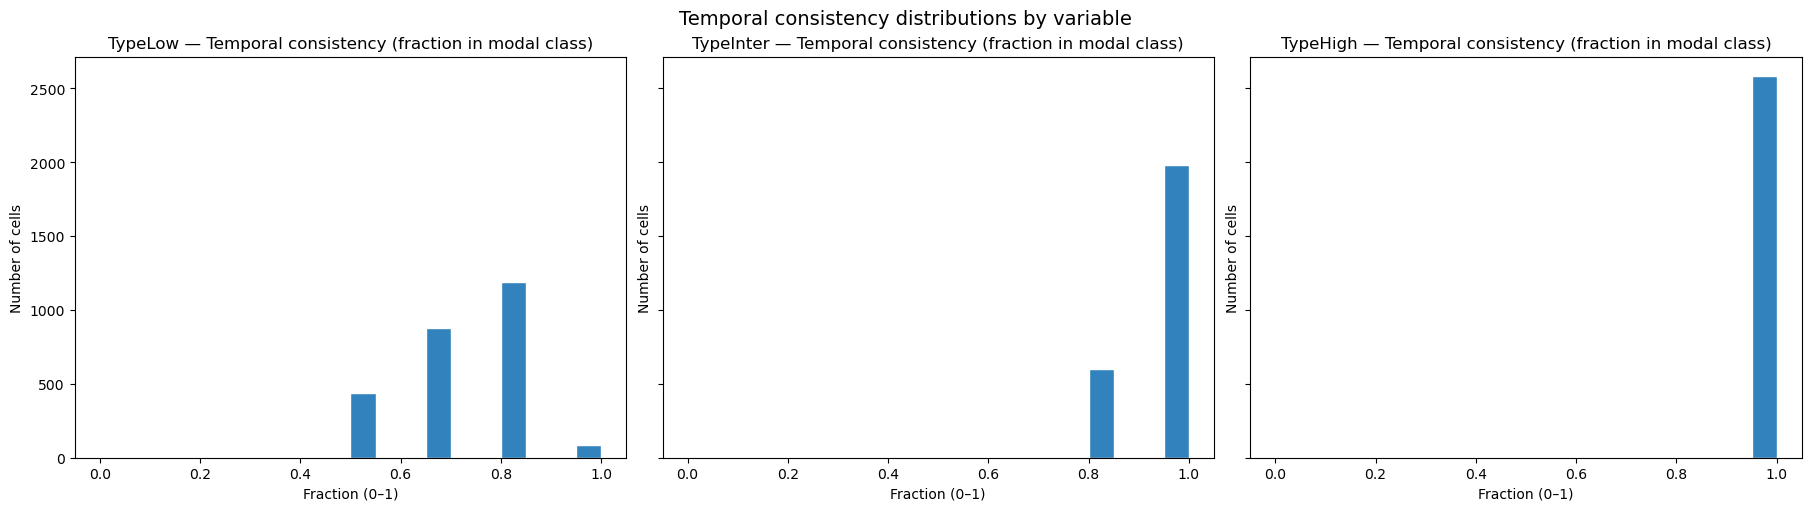

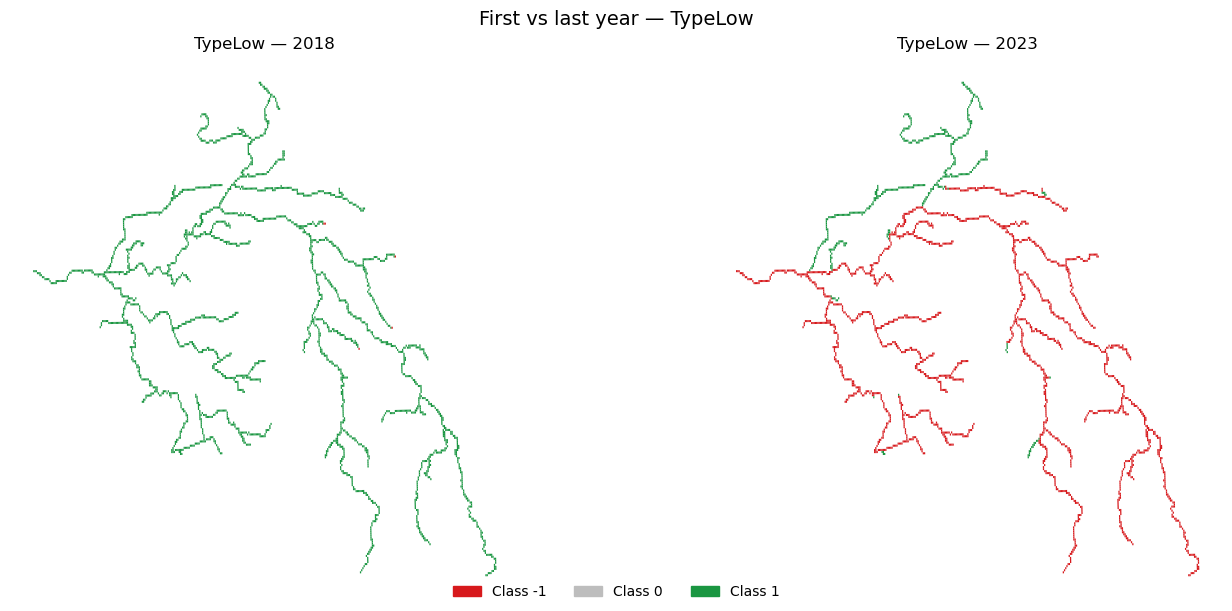

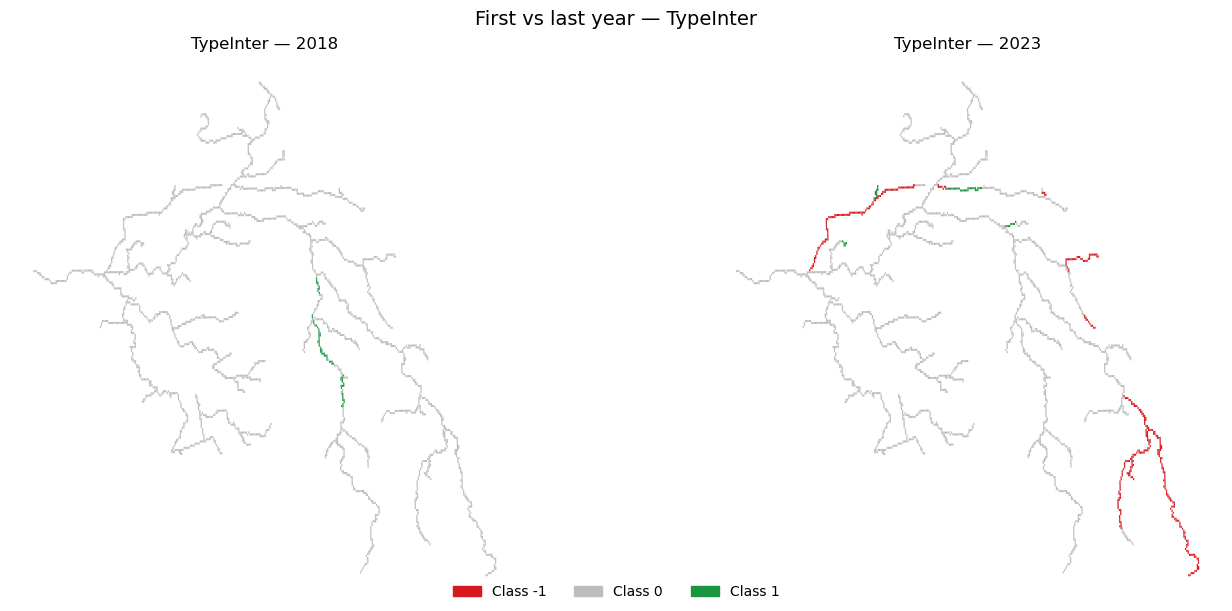

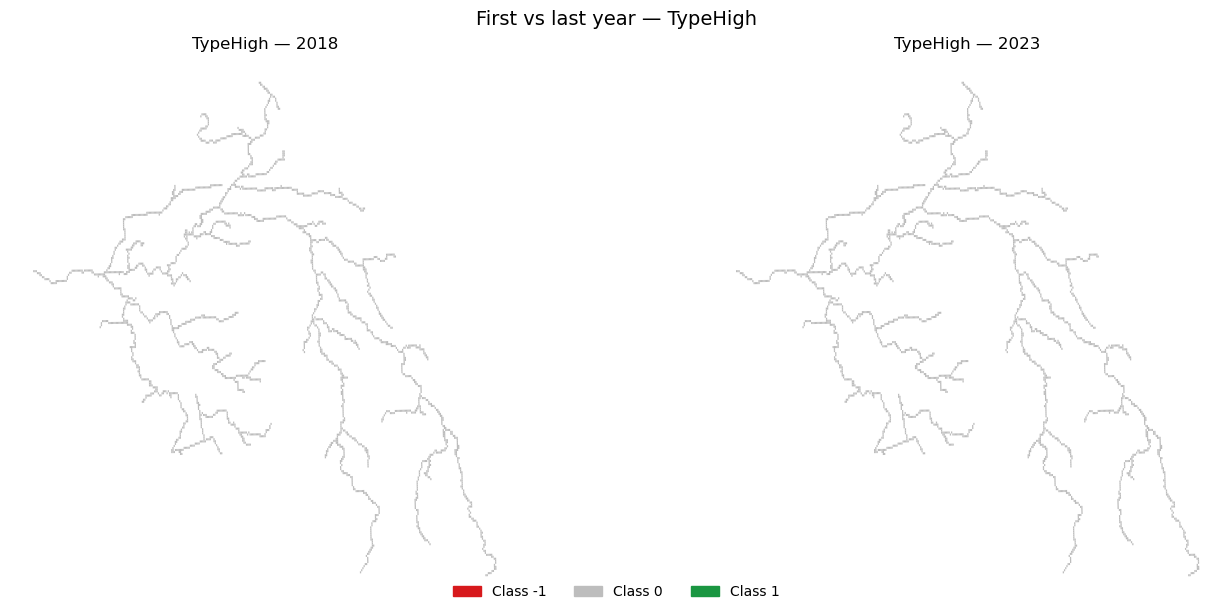

In [11]:
# -*- coding: utf-8 -*-
"""
PLOTTING ONLY:
- Reads the combined layer 'eflows_all_years' from a GeoPackage.
- Produces and DISPLAYS:
  (1) Stacked bar charts of area (km²) per year by class, for each variable,
  (2) Stacked bar charts of area share (0–1) per year by class, for each variable,
  (3) Histograms of temporal consistency per variable,
  (4) First vs last year side-by-side maps for TypeLow, TypeInter, TypeHigh.

Assumptions:
- GeoPackage exists at: example_output_data/shapefile_output_eflows/eflows_28992_all_years.gpkg
- Combined layer is named: 'eflows_all_years'
- Variables are: TypeLow, TypeInter, TypeHigh with classes in {-1, 0, 1}
- Initial CRS of features may be EPSG:4326; areas/maps are computed in EPSG:28992.
- No files are written—plots are shown with plt.show().
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import hashlib

# ----------------------------
# CONFIG
# ----------------------------

# Data location (adjust if needed)
data_dir = Path(r'example_output_data/shapefile_output_eflows')
gpkg_path = data_dir / "eflows_28992_all_years.gpkg"
combined_layer_name = "eflows_all_years"

# Variables / classes to visualize
variables = ["TypeLow", "TypeInter", "TypeHigh"]
classes   = [-1, 0, 1]

# Colors per class (consistent across all charts and maps)
class_colors = {
    -1: "#d7191c",  # red
     0: "#bdbdbd",  # grey
     1: "#1a9641",  # green
}

# CRS names
CRS_SOURCE = "EPSG:4326"   # WGS 84 (lat/lon)
CRS_AREA   = "EPSG:28992"  # Amersfoort / RD New (meters; good for NL)

# ----------------------------
# HELPERS
# ----------------------------

def to_int_class(series: pd.Series) -> pd.Series:
    """Convert class series to ints {-1,0,1} robustly; keep NaNs before dropping."""
    s = pd.to_numeric(series, errors="coerce")
    return s.round().astype("Int64")

def force_area_crs(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Ensure GeoDataFrame is in EPSG:28992 for area and map plotting:
    - If CRS missing: assume EPSG:4326 (per data), then project to 28992.
    - If CRS=4326: project to 28992.
    - Else: project to 28992 if needed.
    """
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_SOURCE).to_crs(CRS_AREA)
    else:
        epsg = gdf.crs.to_epsg()
        if epsg != 28992:
            gdf = gdf.to_crs(CRS_AREA)
    return gdf

def ensure_area_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Ensure per-feature areas exist (in m²/km²)."""
    if "area_m2" not in gdf.columns:
        gdf["area_m2"] = gdf.geometry.area
    if "area_km2" not in gdf.columns:
        gdf["area_km2"] = gdf["area_m2"] / 1_000_000.0
    return gdf

def detect_or_build_cell_id(gdf: gpd.GeoDataFrame) -> tuple[gpd.GeoDataFrame, str]:
    """
    Find a stable cell identifier column or create one from geometry hash (WKB).
    """
    candidates = ["cell_id", "CellID", "face_id", "FaceID", "fid",
                  "mesh2d_face", "ugrid_face", "element", "elem_id", "poly_id"]
    for c in candidates:
        if c in gdf.columns:
            return gdf, c
    gdf = gdf.copy()
    gdf["cell_id"] = gdf.geometry.apply(lambda geom: hashlib.md5(geom.wkb).hexdigest())
    return gdf, "cell_id"

# ----------------------------
# LOAD COMBINED LAYER & PREP
# ----------------------------

if not gpkg_path.exists():
    raise FileNotFoundError(f"GeoPackage not found: {gpkg_path}")

# Read combined layer
gdf_all = gpd.read_file(gpkg_path, layer=combined_layer_name)

# Project to EPSG:28992 for area & maps
gdf_all = force_area_crs(gdf_all)
gdf_all = ensure_area_columns(gdf_all)

# Year sanity check
if "year" not in gdf_all.columns:
    raise RuntimeError("Combined layer lacks a 'year' column.")

years = (pd.to_numeric(gdf_all["year"], errors="coerce")
         .dropna().astype(int).sort_values().unique().tolist())
if not years:
    raise RuntimeError("No valid years found in 'year' field.")
first_year, last_year = years[0], years[-1]

# ----------------------------
# A) YEARLY AREA (km²) — STACKED BARS
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True, sharey=True)

for ax, var in zip(axes, variables):
    if var not in gdf_all.columns:
        ax.set_title(f"{var} — column missing")
        ax.axis("off")
        continue

    # Prepare per-year, per-class km²
    s_class = to_int_class(gdf_all[var])
    dfv = gdf_all[["year", "area_km2"]].copy()
    dfv["class"] = s_class
    dfv = dfv.dropna(subset=["class", "year"]).copy()
    dfv["year"] = dfv["year"].astype(int)
    dfv["class"] = dfv["class"].astype(int)

    by = (dfv.groupby(["year", "class"], as_index=False)["area_km2"].sum())
    pv = (by.pivot_table(index="year", columns="class", values="area_km2", aggfunc="sum")
            .reindex(index=years)        # ensure chronological order
            .fillna(0.0))

    # Ensure all classes present as columns in order -1,0,1
    for cl in classes:
        if cl not in pv.columns:
            pv[cl] = 0.0
    pv = pv[[cl for cl in classes]]

    pv.plot(kind="bar", stacked=True,
            color=[class_colors[c] for c in classes],
            ax=ax, width=0.9, edgecolor="none")

    ax.set_title(f"{var} — Area per year (km²)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Area (km²)")
    ax.legend(title="Class", labels=[str(c) for c in classes], frameon=False)

fig.suptitle("Yearly area by class (km²)", fontsize=14)
plt.show()

# ----------------------------
# B) YEARLY AREA SHARE (0–1) — STACKED BARS
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True, sharey=True)

for ax, var in zip(axes, variables):
    if var not in gdf_all.columns:
        ax.set_title(f"{var} — column missing")
        ax.axis("off")
        continue

    # Per-year % share = class_km2 / total_km2 for that variable/year
    s_class = to_int_class(gdf_all[var])
    dfv = gdf_all[["year", "area_km2"]].copy()
    dfv["class"] = s_class
    dfv = dfv.dropna(subset=["class", "year"]).copy()
    dfv["year"] = dfv["year"].astype(int)
    dfv["class"] = dfv["class"].astype(int)

    by = (dfv.groupby(["year", "class"], as_index=False)["area_km2"].sum())
    pv = (by.pivot_table(index="year", columns="class", values="area_km2", aggfunc="sum")
            .reindex(index=years)
            .fillna(0.0))

    # Ensure all class columns
    for cl in classes:
        if cl not in pv.columns:
            pv[cl] = 0.0
    pv = pv[[cl for cl in classes]]

    totals = pv.sum(axis=1).replace(0, np.nan)
    pct = (pv.div(totals, axis=0).fillna(0.0))

    pct.plot(kind="bar", stacked=True,
             color=[class_colors[c] for c in classes],
             ax=ax, width=0.9, edgecolor="none")

    ax.set_title(f"{var} — Area share per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Share (0–1)")
    ax.legend(title="Class", labels=[str(c) for c in classes], frameon=False)

fig.suptitle("Yearly area shares by class (0–1)", fontsize=14)
plt.show()

# ----------------------------
# C) TEMPORAL CONSISTENCY — HISTOGRAMS
# Definition per (cell, variable):
#   consistency = (# years in cell's modal class) / (# valid years)
# ----------------------------
# Ensure a cell id exists or build one (not strictly required for maps/bars, but needed here)
id_col = None
for c in ["cell_id", "CellID", "face_id", "FaceID", "fid",
          "mesh2d_face", "ugrid_face", "element", "elem_id", "poly_id"]:
    if c in gdf_all.columns:
        id_col = c
        break
if id_col is None:
    gdf_all = gdf_all.copy()
    gdf_all["cell_id"] = gdf_all.geometry.apply(lambda geom: hashlib.md5(geom.wkb).hexdigest())
    id_col = "cell_id"

# Compute consistency per variable
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True, sharey=True)

for ax, var in zip(axes, variables):
    if var not in gdf_all.columns:
        ax.set_title(f"{var} — column missing")
        ax.axis("off")
        continue

    # Build long form (cell, year, class)
    s_class = to_int_class(gdf_all[var])
    dfv = gdf_all[[id_col, "year"]].copy()
    dfv["class"] = s_class
    dfv = dfv.dropna(subset=["class", "year"]).copy()

    if dfv.empty:
        ax.set_title(f"{var} — no data")
        continue

    # Modal class per cell
    modal = (dfv.groupby(id_col)["class"]
               .agg(lambda x: pd.Series(x).value_counts().idxmax())
               .rename("modal_class")
               .reset_index())

    tmp = dfv.merge(modal, on=id_col, how="left")
    tmp["is_modal"] = (tmp["class"] == tmp["modal_class"]).astype(int)

    cons = (tmp.groupby(id_col, as_index=False)
            .agg(n_years=("is_modal", "size"),
                 n_modal=("is_modal", "sum")))
    cons["consistency"] = np.where(cons["n_years"] > 0,
                                   cons["n_modal"] / cons["n_years"], np.nan)

    # Plot histogram of consistency (0–1)
    ax.hist(cons["consistency"].dropna(), bins=np.linspace(0, 1, 21),
            color="#3182bd", edgecolor="white")
    ax.set_title(f"{var} — Temporal consistency (fraction in modal class)")
    ax.set_xlabel("Fraction (0–1)")
    ax.set_ylabel("Number of cells")

fig.suptitle("Temporal consistency distributions by variable", fontsize=14)
plt.show()

# ----------------------------
# D) MAPS — FIRST vs LAST YEAR SIDE-BY-SIDE
# ----------------------------

def plot_first_last_maps(var: str):
    """
    Side-by-side map for the first and last year for a given variable.
    Uses EPSG:28992 coordinates and class-based colors.
    """
    if var not in gdf_all.columns:
        print(f"Variable '{var}' not found for maps.")
        return

    # Subset to first and last year
    gf = gdf_all[gdf_all["year"] == first_year].copy()
    gl = gdf_all[gdf_all["year"] == last_year].copy()

    # Prep classification & colors
    def prep(gdf):
        s = to_int_class(gdf[var])
        g = gdf.assign(_class=s).dropna(subset=["_class"]).copy()
        g["_color"] = g["_class"].astype(int).map(class_colors).fillna("#999999")
        return g

    gf = prep(gf)
    gl = prep(gl)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    if not gf.empty:
        gf.plot(ax=axes[0], color=gf["_color"], linewidth=0.1, edgecolor="none")
    axes[0].set_title(f"{var} — {first_year}")
    axes[0].set_axis_off()

    if not gl.empty:
        gl.plot(ax=axes[1], color=gl["_color"], linewidth=0.1, edgecolor="none")
    axes[1].set_title(f"{var} — {last_year}")
    axes[1].set_axis_off()

    # Legend
    patches = [mpatches.Patch(color=class_colors[c], label=f"Class {c}") for c in classes]
    fig.legend(handles=patches, loc="lower center", ncol=3, frameon=False)

    fig.suptitle(f"First vs last year — {var}", fontsize=14)
    plt.show()

# Render maps for the three variables
plot_first_last_maps("TypeLow")
plot_first_last_maps("TypeInter")
plot_first_last_maps("TypeHigh")